# Mario Christofell L.Tobing

Project 2 Dicoding Modul Belajar Pengembangan Machine Learning 

*   Machine Learning Model Time Series Indonesia Climate Data 
*   Dataset download from Kaggle : Climate Data Daily IDN (https://www.kaggle.com/datasets/greegtitan/indonesia-climate?select=climate_data.csv)


# Import Library

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras.layers import LSTM,Dense,Bidirectional
from keras.callbacks import EarlyStopping

# Read Dataset into Dataframe

In [213]:
df = pd.read_csv('/content/drive/MyDrive/climate_data.csv') # Link download dataset Kaggle : Climate Data Daily IDN (https://www.kaggle.com/datasets/greegtitan/indonesia-climate?select=climate_data.csv)
df.head()

,date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car,station_id
0,01-01-2010,21.4,30.2,27.1,82.0,9.0,0.5,7.0,90.0,5.0,E,96001
1,02-01-2010,21.0,29.6,25.7,95.0,24.0,0.2,6.0,90.0,4.0,E,96001
2,03-01-2010,20.2,26.8,24.5,98.0,63.0,0.0,5.0,90.0,4.0,E,96001
3,04-01-2010,21.0,29.2,25.8,90.0,0.0,0.1,4.0,225.0,3.0,SW,96001
4,05-01-2010,21.2,30.0,26.7,90.0,2.0,0.4,NaN,NaN,NaN,NaN,96001


In [214]:
df.drop(['Tn','Tx','RH_avg', 'RR','ss','ff_x','ddd_x','ff_avg','ddd_car','station_id'], axis=1, inplace=True) # drop column yang tidak dipakai
df

,date,Tavg
0,01-01-2010,27.1
1,02-01-2010,25.7
2,03-01-2010,24.5
3,04-01-2010,25.8
4,05-01-2010,26.7
...,...,...
589260,27-12-2020,29.2
589261,28-12-2020,28.1
589262,29-12-2020,28.4
589263,30-12-2020,28.4


In [215]:
df['date'] = pd.to_datetime(df['date'])  
get_data = (df['date'] > '01-01-2020') & (df['date'] <= '31-12-2020') # mengambil sampel data dari tahun 2020
df.loc[get_data]

df = df.loc[get_data]
df

,date,Tavg
3548,2020-02-01,26.4
3549,2020-03-01,27.1
3550,2020-04-01,26.6
3551,2020-05-01,26.8
3552,2020-06-01,26.6
...,...,...
589260,2020-12-27,29.2
589261,2020-12-28,28.1
589262,2020-12-29,28.4
589263,2020-12-30,28.4


In [216]:
df.reset_index(drop=True)

,date,Tavg
0,2020-02-01,26.4
1,2020-03-01,27.1
2,2020-04-01,26.6
3,2020-05-01,26.8
4,2020-06-01,26.6
...,...,...
56107,2020-12-27,29.2
56108,2020-12-28,28.1
56109,2020-12-29,28.4
56110,2020-12-30,28.4


In [217]:
df.info() # info dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56112 entries, 3548 to 589264
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    56112 non-null  datetime64[ns]
 1   Tavg    49781 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.3 MB


In [218]:
df.isnull().sum() # mengecek adakah nilai yang hilang pada dataset

date       0
Tavg    6331
dtype: int64

In [219]:
df.dropna(subset=['Tavg'],inplace=True) # mendrop baris pada kolom Tavg yg tidak memiliki nilai atau null/Nan
df.isnull().sum()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


date    0
Tavg    0
dtype: int64

Membuat plot dataset Indonesia Climate 2020 

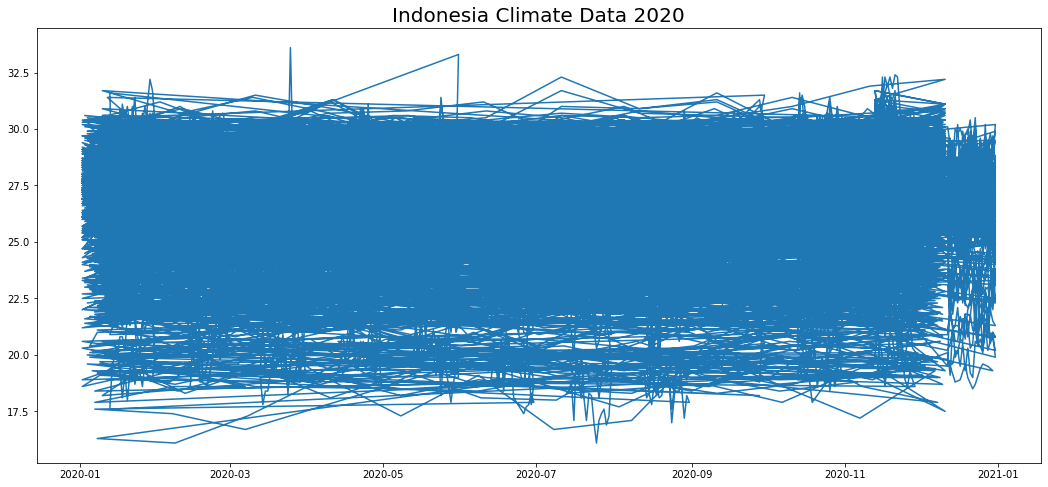

In [232]:
dates = df['date'].values
tempavg  = df['Tavg'].values


plt.figure(figsize=(18,8))
plt.plot(dates, tempavg)
plt.title('Indonesia Climate Data 2020',fontsize=20);

# Split Dataset

In [221]:
x_train, x_test, y_train, y_test = train_test_split(tempavg, dates, test_size = 0.2, shuffle = False)  # pembagian dataset untuk data test/validation sebesar 20% dari total keseluruhan data

# Model

Mengubah format data untuk dapat diterima oleh model 

In [222]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

Pemodelan Sequential dengan LSTM

In [223]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(LSTM(60)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [224]:
mx = df['Tavg'].max()
print('Max value : ' )
print(mx)

Max value : 
33.6


In [225]:
mn = df['Tavg'].min()
print('Min value : ' )
print(mn)

Min value : 
16.1


In [226]:
m = (33.6 - 16.1) * (10 / 100) # MAE < 10%
print(m)

1.75


Membuat fungsi callback

In [227]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< m and logs.get('val_mae')< m): # Pelatihan berhenti ketika memenuhi nilai MAE < 10% skala data
      print("\nThe MAE has reached < 10% from data scale")
      self.model.stop_training = True
callbacks = myCallback()

Optimizer dan Penggunaan Learning Rate

In [228]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, batch_size=128, validation_data=test_set, callbacks=[callbacks])

Epoch 1/100
398/398 [==============================] - 134s 311ms/step - loss: 13.1289 - mae: 13.5944 - val_loss: 1.0531 - val_mae: 1.4638
Epoch 2/100
398/398 [==============================] - ETA: 0s - loss: 0.8207 - mae: 1.2199
The MAE has reached < 10% from data scale
398/398 [==============================] - 118s 296ms/step - loss: 0.8207 - mae: 1.2199 - val_loss: 0.9793 - val_mae: 1.3851


Visualization Plot MAE and Loss 

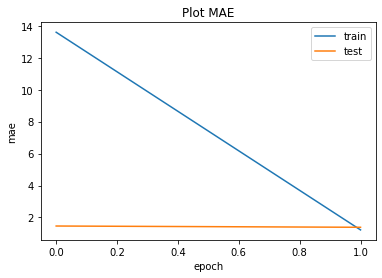

In [231]:
plt.plot(history.history['mae']) # plot MAE
plt.plot(history.history['val_mae'])
plt.title('Plot MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

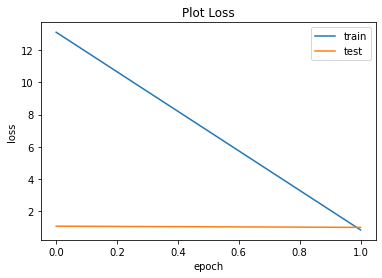

In [230]:
plt.plot(history.history['loss']) # plot loss
plt.plot(history.history['val_loss'])
plt.title('Plot Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()